# **Implementacion RFOA**

In [26]:
import time
import numpy as np
import random
import matplotlib.pyplot as plt

## Funciones

In [4]:
class RFOA_Optimizer:
    """
    Implementación del Rain-Fall Optimization Algorithm (RFOA).
    Separa claramente la fase de 'Lluvia' (Inicialización) y 'Escorrentía' (Movimiento).
    """
    def __init__(self, num_raindrops=50, max_iter=100, neighbor_radius=1.0):
        self.num_raindrops = num_raindrops
        self.max_iter = max_iter
        self.base_radius = neighbor_radius

        # Estado interno
        self.raindrops = None       # Población de soluciones
        self.scores = None          # Puntajes de las soluciones
        self.best_solution = None   # Mejor solución global
        self.best_score = -np.inf   # Mejor puntaje global
        self.history = []           # Para la gráfica

    # lluvia
    def generate_rain(self, problem_dim, constraint_func, fitness_func):
        """
        Fase 1: Lluvia.
        Genera las gotas (soluciones) iniciales aleatoriamente en el espacio de búsqueda.
        """
        print("--> [Fase Lluvia] Generando población inicial...")

        # 1. Crear gotas aleatorias
        raw_drops = np.random.rand(self.num_raindrops, problem_dim)

        # 2. Aplicar restricciones (ajustar al presupuesto, etc.)
        self.raindrops = np.array([constraint_func(d) for d in raw_drops])

        # 3. Evaluar dónde cayeron
        self.scores = np.array([fitness_func(d) for d in self.raindrops])

        # 4. Registrar el mejor inicial
        best_idx = np.argmax(self.scores)
        self.best_solution = self.raindrops[best_idx].copy()
        self.best_score = self.scores[best_idx]
        self.history.append(self.best_score)

    # escorrentia
    def runoff_process(self, current_iter, problem_dim, constraint_func, fitness_func):
        # Simula el movimiento del agua buscando vecinos que mejoren la funcion objetivo
        # El radio de búsqueda disminuye a medida que avanza el tiempo
        current_radius = self.base_radius * (1 - current_iter / self.max_iter)

        for i in range(self.num_raindrops):
            current_drop = self.raindrops[i]

            # --- A. Generar un camino potencial (Vecino) ---
            # Ruido aleatorio dentro del radio actual
            noise = np.random.uniform(-current_radius, current_radius, problem_dim)
            potential_move = current_drop + noise

            # Asegurar que el movimiento es válido (Restricciones)
            neighbor = constraint_func(potential_move)

            # --- B. Evaluar si fluye hacia allí ---
            neighbor_score = fitness_func(neighbor)

            # Regla del RFOA: Si el vecino mejora, el agua fluye hacia él
            if neighbor_score > self.scores[i]:
                self.raindrops[i] = neighbor
                self.scores[i] = neighbor_score

                # Actualizar el Mejor Global si superamos el récord
                if neighbor_score > self.best_score:
                    self.best_score = neighbor_score
                    self.best_solution = neighbor.copy()

            else:
                # Si no encuentra camino mejor, intenta ir hacia el mejor global para no estancarse
                step_to_best = 0.1 * np.random.rand() * (self.best_solution - current_drop)
                alt_move = constraint_func(current_drop + step_to_best)
                alt_score = fitness_func(alt_move)

                if alt_score > self.scores[i]:
                    self.raindrops[i] = alt_move
                    self.scores[i] = alt_score


    # bucle principal
    def optimize(self, problem_dim, fitness_func, constraint_func):
        #Ejecuta el ciclo completo: Lluvia -> Bucle de Escorrentía

        # 1. generamos la lluvia (poblacion inicial)
        self.generate_rain(problem_dim, constraint_func, fitness_func)

        # 2. vamos iterando
        for it in range(self.max_iter):
            self.runoff_process(it, problem_dim, constraint_func, fitness_func)
            self.history.append(self.best_score)

        return self.best_solution, self.best_score, self.history

## Ejecución del Problema

In [8]:
class RFOA:
    def __init__(self, tasks_data, budget):
        self.tasks = tasks_data
        self.budget = budget
        self.dim = len(tasks_data)

        # Pre-calculamos eficiencias (Rendimiento / Recurso)
        self.efficiencies = []
        for t in self.tasks:
            # Si el recurso base es 0, evitamos división por cero
            denom = t['ref_resource'] if t['ref_resource'] > 0 else 1
            eff = t['ref_yield'] / denom
            self.efficiencies.append(eff)
        self.efficiencies = np.array(self.efficiencies)

    def constraint_manager(self, solution):
        """
        Asegura que el vector de solución sea válido:
        1. Sin valores negativos.
        2. La suma total debe ser igual al Presupuesto.
        """
        solution = np.maximum(solution, 0) # Eliminar negativos
        total_used = np.sum(solution)

        if total_used > 0:
            # Normalizar: (valor / suma_actual) * presupuesto
            return (solution / total_used) * self.budget
        else:
            # Si el vector es todo ceros, reiniciar aleatoriamente
            r = np.random.rand(self.dim)
            return (r / np.sum(r)) * self.budget

    def fitness_function(self, solution):
        """
        Evaluación Lineal: Suma (Recurso Asignado * Eficiencia)
        """
        return np.sum(solution * self.efficiencies)

# Problema enunciado

In [9]:
data_pdf = [
    {'name': 'T1', 'ref_resource': 1.0, 'ref_yield': 5.0},
    {'name': 'T2', 'ref_resource': 2.0, 'ref_yield': 10.0},
    {'name': 'T3', 'ref_resource': 3.0, 'ref_yield': 15.0},
    {'name': 'T4', 'ref_resource': 4.0, 'ref_yield': 20.0},
    {'name': 'T5', 'ref_resource': 5.0, 'ref_yield': 30.0}
]
problem1 = RFOA(data_pdf, budget=10.0)

print(">>> EJECUTANDO INSTANCIA 1 (PDF - 5 Tareas)")
optimizer1 = RFOA_Optimizer(num_raindrops=50, max_iter=80, neighbor_radius=2.0)
sol1, score1, hist1 = optimizer1.optimize(
    problem1.dim,
    problem1.fitness_function,
    problem1.constraint_manager
)

>>> EJECUTANDO INSTANCIA 1 (PDF - 5 Tareas)
--> [Fase Lluvia] Generando población inicial...


Mostrar Resultados


RESULTADOS INSTANCIA 1 (Objetivo: 60.0)
Mejor Rendimiento: 60.0000
Asignación de Recursos:
  T1: 0.0000
  T2: 0.0000
  T3: 0.0000
  T4: 0.0000
  T5: 10.0000


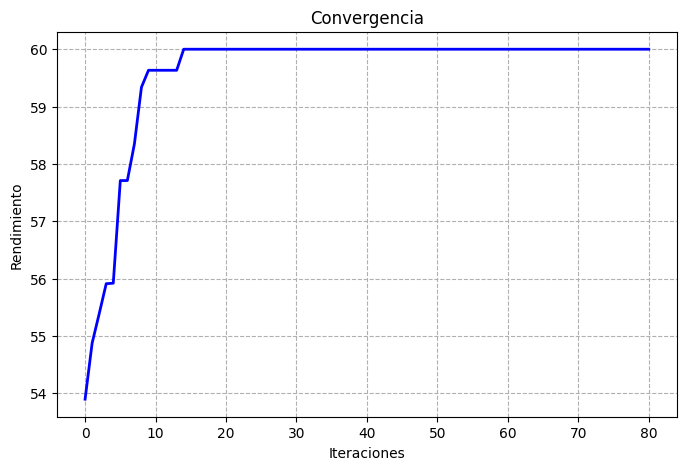

In [14]:
print("\n" + "="*40)
print(f"RESULTADOS INSTANCIA 1 (Objetivo: 60.0)")
print("="*40)
print(f"Mejor Rendimiento: {score1:.4f}")
print("Asignación de Recursos:")
for i, task in enumerate(data_pdf):
    print(f"  {task['name']}: {sol1[i]:.4f}")

# Grafico
plt.figure(figsize=(8, 5))
plt.plot(hist1, color='blue', linewidth=2)
plt.title("Convergencia")
plt.xlabel("Iteraciones")
plt.ylabel("Rendimiento")
plt.grid(True, linestyle='--')
plt.show()

Problema más grande: 20 tareas

In [17]:
np.random.seed(42)
data_large = []
for i in range(20):
    # Recursos de ref aleatorios entre 1 y 5, Rendimiento aleatorio
    res = np.random.randint(1, 6)
    yld = res * np.random.uniform(2, 8) # Eficiencia variable entre 2 y 8
    data_large.append({'name': f'T{i}', 'ref_resource': res, 'ref_yield': yld})
presupuesto2 = 100.0

problem2 = RFOA(data_large, budget=100.0)

print("\n>>> EJECUTANDO INSTANCIA 2 (Grande - 20 Tareas)")
optimizer2 = RFOA_Optimizer(num_raindrops=100, max_iter=150, neighbor_radius=5.0)
sol2, score2, hist2 = optimizer2.optimize(
    problem2.dim,
    problem2.fitness_function,
    problem2.constraint_manager
)


>>> EJECUTANDO INSTANCIA 2 (Grande - 20 Tareas)
--> [Fase Lluvia] Generando población inicial...


Resultados


RESULTADOS INSTANCIA 2 (20 Tareas)
Mejor Rendimiento Encontrado: 732.5859
La tarea más eficiente era la T0 (Eficiencia: 7.70)
Dinero asignado a T0 por el algoritmo: 25.9471 (de 100.0)


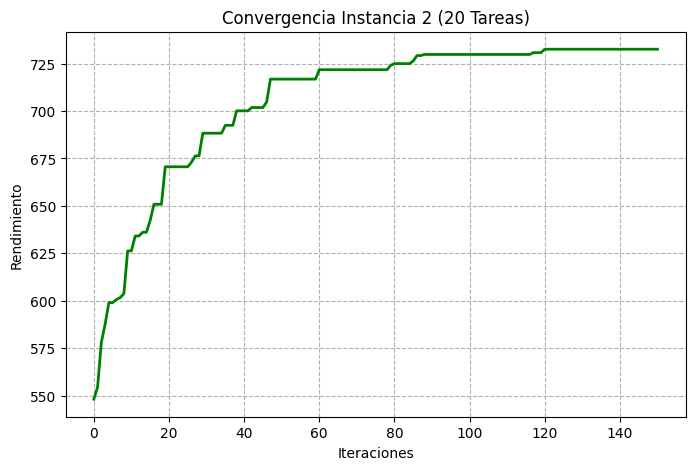

In [18]:
best_idx_real = np.argmax(problem2.efficiencies)
best_eff_real = problem2.efficiencies[best_idx_real]

print("\n" + "="*40)
print(f"RESULTADOS INSTANCIA 2 (20 Tareas)")
print("="*40)
print(f"Mejor Rendimiento Encontrado: {score2:.4f}")
print(f"La tarea más eficiente era la T{best_idx_real} (Eficiencia: {best_eff_real:.2f})")
print(f"Dinero asignado a T{best_idx_real} por el algoritmo: {sol2[best_idx_real]:.4f} (de {presupuesto2})")

# Grafico
plt.figure(figsize=(8, 5))
plt.plot(hist2, color='green', linewidth=2)
plt.title("Convergencia Instancia 2 (20 Tareas)")
plt.xlabel("Iteraciones")
plt.ylabel("Rendimiento")
plt.grid(True, linestyle='--')
plt.show()

## Comparación con otros métodos

AAGG

In [19]:
class GeneticAlgorithm:
    def __init__(self, problem, pop_size=50, generations=100, mutation_rate=0.1):
        self.p = problem
        self.pop_size = pop_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.best_score = -np.inf

    def run(self):
        # Población inicial
        pop = np.random.rand(self.pop_size, self.p.dim)
        pop = np.array([self.p.constraints(ind) for ind in pop])

        for _ in range(self.generations):
            scores = np.array([self.p.fitness(ind) for ind in pop])

            # Guardar el mejor (Elitismo)
            best_gen = np.max(scores)
            if best_gen > self.best_score:
                self.best_score = best_gen

            # Selección (Torneo)
            new_pop = []
            for _ in range(self.pop_size):
                # Elegir 2 padres al azar y quedarse con el mejor
                candidates_idx = np.random.choice(self.pop_size, 2)
                winner_idx = candidates_idx[np.argmax(scores[candidates_idx])]
                new_pop.append(pop[winner_idx])
            new_pop = np.array(new_pop)

            # Cruzamiento (Crossover Aritmético) y Mutación
            next_gen = []
            for i in range(0, self.pop_size, 2):
                p1 = new_pop[i]
                p2 = new_pop[(i+1)%self.pop_size]

                # Crossover
                alpha = np.random.rand()
                c1 = alpha*p1 + (1-alpha)*p2
                c2 = (1-alpha)*p1 + alpha*p2

                # Mutación
                if np.random.rand() < self.mutation_rate:
                    c1 += np.random.normal(0, 0.5, self.p.dim)
                if np.random.rand() < self.mutation_rate:
                    c2 += np.random.normal(0, 0.5, self.p.dim)

                next_gen.append(self.p.constraints(c1))
                next_gen.append(self.p.constraints(c2))

            pop = np.array(next_gen)[:self.pop_size]

        return self.best_score

Búsqueda aleatoria

In [20]:
class RandomSearch:
    def __init__(self, problem, iterations=5000):
        self.p = problem
        self.iterations = iterations # Muchas iteraciones para ser justo

    def run(self):
        best = -np.inf
        for _ in range(self.iterations):
            sol = np.random.rand(self.p.dim)
            sol = self.p.constraints(sol)
            score = self.p.fitness(sol)
            if score > best:
                best = score
        return best

--- INICIANDO COMPARATIVA (10 ejecuciones por algoritmo) ---
--> [Fase Lluvia] Generando población inicial...
--> [Fase Lluvia] Generando población inicial...
--> [Fase Lluvia] Generando población inicial...
--> [Fase Lluvia] Generando población inicial...
--> [Fase Lluvia] Generando población inicial...
--> [Fase Lluvia] Generando población inicial...
--> [Fase Lluvia] Generando población inicial...
--> [Fase Lluvia] Generando población inicial...
--> [Fase Lluvia] Generando población inicial...
--> [Fase Lluvia] Generando población inicial...

RESULTADOS PROMEDIO (10 ejecuciones)
Algoritmo            | Score Medio     | Tiempo Medio (s)
------------------------------------------------------------
RFOA                 | 60.0000         | 0.16257        
Genético (GA)        | 60.0000         | 0.19637        
Aleatorio            | 57.4870         | 0.07417        
------------------------------------------------------------
Óptimo Teórico       | 60.0000         | -              


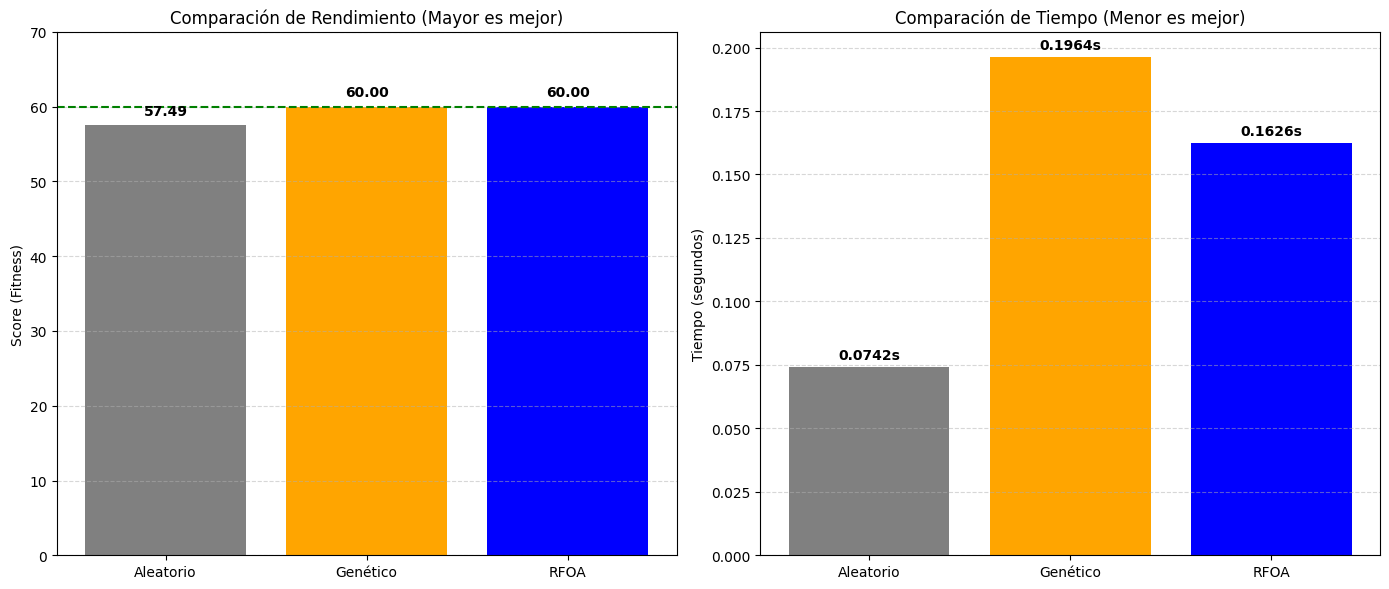

In [27]:
if not hasattr(problem1, 'constraints'):
    problem1.constraints = problem1.constraint_manager
if not hasattr(problem1, 'fitness'):
    problem1.fitness = problem1.fitness_function

# --- 2. CONFIGURACIÓN ---
N_RUNS = 10
print(f"--- INICIANDO COMPARATIVA ({N_RUNS} ejecuciones por algoritmo) ---")

# Almacenar resultados (Puntajes y Tiempos)
results_rfoa = []
times_rfoa = []

results_ga = []
times_ga = []

results_random = []
times_random = []

for i in range(N_RUNS):
    # --- RFOA ---
    start_t = time.time()
    opt_rfoa = RFOA_Optimizer(num_raindrops=50, max_iter=80, neighbor_radius=2.0)
    _, score_rfoa, _ = opt_rfoa.optimize(
        problem1.dim,
        problem1.fitness_function,
        problem1.constraint_manager
    )
    end_t = time.time()
    results_rfoa.append(score_rfoa)
    times_rfoa.append(end_t - start_t)

    # --- GA (Algoritmo Genético) ---
    start_t = time.time()
    ga = GeneticAlgorithm(problem1, pop_size=50, generations=100)
    score_ga = ga.run()
    end_t = time.time()
    results_ga.append(score_ga)
    times_ga.append(end_t - start_t)

    # --- Búsqueda Aleatoria ---
    start_t = time.time()
    rnd = RandomSearch(problem1, iterations=5000)
    score_rnd = rnd.run()
    end_t = time.time()
    results_random.append(score_rnd)
    times_random.append(end_t - start_t)

# --- 3. CÁLCULO DE PROMEDIOS ---
# Scores
avg_rfoa = np.mean(results_rfoa)
avg_ga = np.mean(results_ga)
avg_rnd = np.mean(results_random)
optimal_val = 60.0

# Tiempos
avg_time_rfoa = np.mean(times_rfoa)
avg_time_ga = np.mean(times_ga)
avg_time_rnd = np.mean(times_random)

# --- 4. REPORTE DE TEXTO ---
print("\n" + "="*60)
print(f"RESULTADOS PROMEDIO ({N_RUNS} ejecuciones)")
print("="*60)
print(f"{'Algoritmo':<20} | {'Score Medio':<15} | {'Tiempo Medio (s)':<15}")
print("-" * 60)
print(f"{'RFOA':<20} | {avg_rfoa:<15.4f} | {avg_time_rfoa:<15.5f}")
print(f"{'Genético (GA)':<20} | {avg_ga:<15.4f} | {avg_time_ga:<15.5f}")
print(f"{'Aleatorio':<20} | {avg_rnd:<15.4f} | {avg_time_rnd:<15.5f}")
print("-" * 60)
print(f"{'Óptimo Teórico':<20} | {optimal_val:<15.4f} | {'-':<15}")
print("="*60)

# --- 5. GRÁFICAS COMPARATIVAS ---
algorithms = ['Aleatorio', 'Genético', 'RFOA']
scores_final = [avg_rnd, avg_ga, avg_rfoa]
times_final = [avg_time_rnd, avg_time_ga, avg_time_rfoa]
colors = ['gray', 'orange', 'blue']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfica 1: Rendimiento (Score)
bars1 = ax1.bar(algorithms, scores_final, color=colors)
ax1.axhline(y=optimal_val, color='green', linestyle='--', label='Óptimo')
ax1.set_title('Comparación de Rendimiento (Mayor es mejor)')
ax1.set_ylabel('Score (Fitness)')
ax1.set_ylim(0, 70)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Etiquetas Score
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}', ha='center', va='bottom', fontweight='bold')

# Gráfica 2: Tiempo de Ejecución
bars2 = ax2.bar(algorithms, times_final, color=colors)
ax2.set_title('Comparación de Tiempo (Menor es mejor)')
ax2.set_ylabel('Tiempo (segundos)')
ax2.grid(axis='y', linestyle='--', alpha=0.5)

# Etiquetas Tiempo
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval + (max(times_final)*0.01), f'{yval:.4f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

--- INICIANDO COMPARATIVA PROBLEM 2 (10 ejecuciones por algoritmo) ---
Dimensiones: 20 tareas | Presupuesto: 100.0
--> [Fase Lluvia] Generando población inicial...
--> [Fase Lluvia] Generando población inicial...
--> [Fase Lluvia] Generando población inicial...
--> [Fase Lluvia] Generando población inicial...
--> [Fase Lluvia] Generando población inicial...
--> [Fase Lluvia] Generando población inicial...
--> [Fase Lluvia] Generando población inicial...
--> [Fase Lluvia] Generando población inicial...
--> [Fase Lluvia] Generando población inicial...
--> [Fase Lluvia] Generando población inicial...

RESULTADOS PROMEDIO - PROBLEM 2 (10 ejecuciones)
Algoritmo            | Score Medio     | Tiempo Medio (s)
------------------------------------------------------------
RFOA                 | 731.0815        | 0.66694        
Genético (GA)        | 656.4600        | 0.64001        
Aleatorio            | 585.3558        | 0.24380        
-------------------------------------------------------

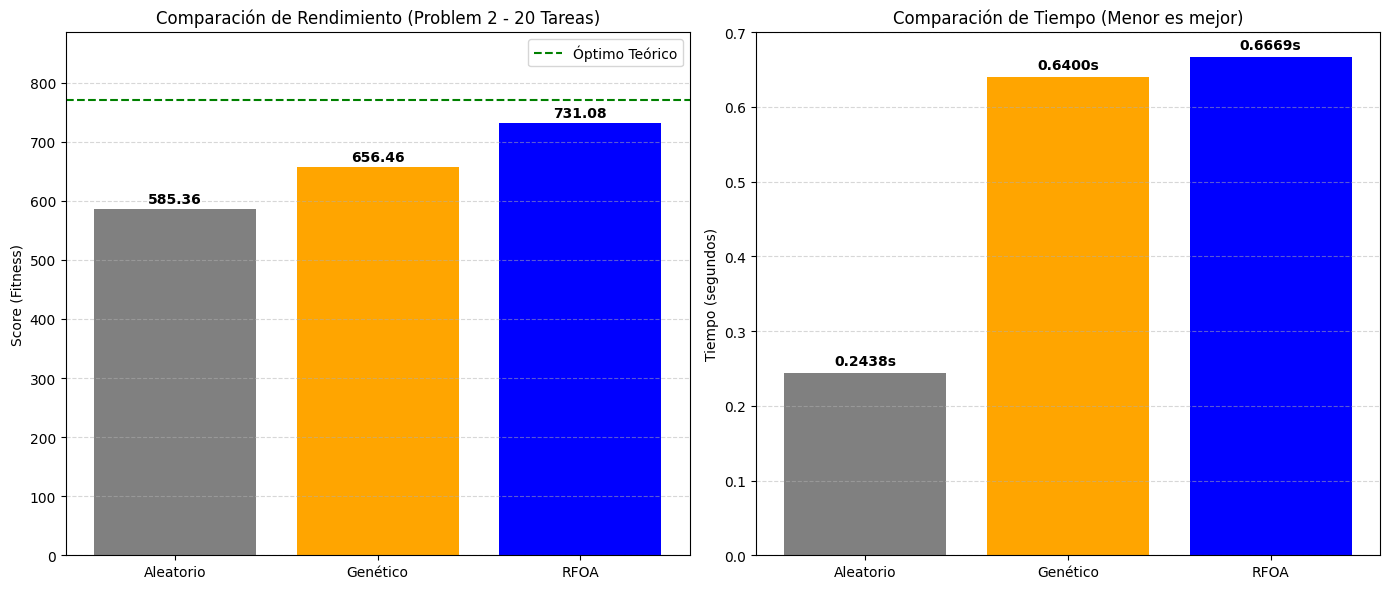

In [28]:
if not hasattr(problem2, 'constraints'):
    problem2.constraints = problem2.constraint_manager
if not hasattr(problem2, 'fitness'):
    problem2.fitness = problem2.fitness_function

# --- 2. CÁLCULO DEL ÓPTIMO TEÓRICO (Dinámico) ---
# En este problema, el óptimo es asignar todo el presupuesto a la tarea más eficiente.
max_efficiency_idx = np.argmax(problem2.efficiencies)
max_efficiency_val = problem2.efficiencies[max_efficiency_idx]
optimal_val_2 = max_efficiency_val * problem2.budget

# --- 3. CONFIGURACIÓN ---
N_RUNS = 10
print(f"--- INICIANDO COMPARATIVA PROBLEM 2 ({N_RUNS} ejecuciones por algoritmo) ---")
print(f"Dimensiones: {problem2.dim} tareas | Presupuesto: {problem2.budget}")

# Almacenar resultados (Puntajes y Tiempos)
results_rfoa = []
times_rfoa = []

results_ga = []
times_ga = []

results_random = []
times_random = []

for i in range(N_RUNS):
    # --- RFOA ---
    # Parámetros aumentados para el problema de 20 dimensiones
    start_t = time.time()
    opt_rfoa = RFOA_Optimizer(num_raindrops=100, max_iter=150, neighbor_radius=5.0)
    _, score_rfoa, _ = opt_rfoa.optimize(
        problem2.dim,
        problem2.fitness_function,
        problem2.constraint_manager
    )
    end_t = time.time()
    results_rfoa.append(score_rfoa)
    times_rfoa.append(end_t - start_t)

    # --- GA (Algoritmo Genético) ---
    # Aumentamos población y generaciones para competir en 20D
    start_t = time.time()
    ga = GeneticAlgorithm(problem2, pop_size=100, generations=150)
    score_ga = ga.run()
    end_t = time.time()
    results_ga.append(score_ga)
    times_ga.append(end_t - start_t)

    # --- Búsqueda Aleatoria ---
    # 15000 iteraciones para igualar aprox el esfuerzo computacional (100 * 150)
    start_t = time.time()
    rnd = RandomSearch(problem2, iterations=15000)
    score_rnd = rnd.run()
    end_t = time.time()
    results_random.append(score_rnd)
    times_random.append(end_t - start_t)

# --- 4. CÁLCULO DE PROMEDIOS ---
# Scores
avg_rfoa = np.mean(results_rfoa)
avg_ga = np.mean(results_ga)
avg_rnd = np.mean(results_random)

# Tiempos
avg_time_rfoa = np.mean(times_rfoa)
avg_time_ga = np.mean(times_ga)
avg_time_rnd = np.mean(times_random)

# --- 5. REPORTE DE TEXTO ---
print("\n" + "="*60)
print(f"RESULTADOS PROMEDIO - PROBLEM 2 ({N_RUNS} ejecuciones)")
print("="*60)
print(f"{'Algoritmo':<20} | {'Score Medio':<15} | {'Tiempo Medio (s)':<15}")
print("-" * 60)
print(f"{'RFOA':<20} | {avg_rfoa:<15.4f} | {avg_time_rfoa:<15.5f}")
print(f"{'Genético (GA)':<20} | {avg_ga:<15.4f} | {avg_time_ga:<15.5f}")
print(f"{'Aleatorio':<20} | {avg_rnd:<15.4f} | {avg_time_rnd:<15.5f}")
print("-" * 60)
print(f"{'Óptimo Teórico':<20} | {optimal_val_2:<15.4f} | {'-':<15}")
print("="*60)

# --- 6. GRÁFICAS COMPARATIVAS ---
algorithms = ['Aleatorio', 'Genético', 'RFOA']
scores_final = [avg_rnd, avg_ga, avg_rfoa]
times_final = [avg_time_rnd, avg_time_ga, avg_time_rfoa]
colors = ['gray', 'orange', 'blue']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfica 1: Rendimiento (Score)
bars1 = ax1.bar(algorithms, scores_final, color=colors)
ax1.axhline(y=optimal_val_2, color='green', linestyle='--', label='Óptimo Teórico')
ax1.set_title('Comparación de Rendimiento (Problem 2 - 20 Tareas)')
ax1.set_ylabel('Score (Fitness)')
# Ajuste dinámico del límite Y para que se vea bien el óptimo
ax1.set_ylim(0, optimal_val_2 * 1.15)
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.legend()

# Etiquetas Score
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 5, f'{yval:.2f}', ha='center', va='bottom', fontweight='bold')

# Gráfica 2: Tiempo de Ejecución
bars2 = ax2.bar(algorithms, times_final, color=colors)
ax2.set_title('Comparación de Tiempo (Menor es mejor)')
ax2.set_ylabel('Tiempo (segundos)')
ax2.grid(axis='y', linestyle='--', alpha=0.5)

# Etiquetas Tiempo
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval + (max(times_final)*0.01), f'{yval:.4f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()